# Creating a playing cards dataset
This notebook is a guide through the creation of a dataset of playing cards. The cards are labeled with their name (ex: "2c" for "2 of spades", "Kh" for King for hearts) and with the bounding boxes delimiting their printed corners.
> _Why bounding boxes around the corners, and not around the whole card ?_<br>Because in real conditions, more often than not, cards are partially covered. And the corner of a card is the minimum information you need to identify it.

This dataset can be used for the training of a neural net intended to detect/localize playing cards. It was used on the project __[Playing card detection with YOLO v3](https://youtu.be/pnntrewH0xg)__

<img src="img/ex_generated_image.png" alt="Example of generated image "  title="Example of generated image " />


# Prerequisites 

### A. In addition to opencv and numpy, you need the following python packages :
1. **imgaug** : https://github.com/aleju/imgaug 
> Helps with image augmentation
2. **shapely** : https://github.com/Toblerity/Shapely
> For the manipulation and analysis of geometric objects in the Cartesian plane. It is useful here when we want to check if the bounding box of a card corner is covered by another card
3. **tqdm** : https://github.com/tqdm/tqdm
> A progress bar tool. Not mandatory but convenient when you generate thousands of images

### B. Get the Describable Textures Dataset (DTD)
> A collection of textural images in the wild (https://www.robots.ox.ac.uk/~vgg/data/dtd/). It is probably not its original goal, but it is used here as an easy way to generate various backgrounds for our images.

### C. A real deck of cards
> This the only physical "data" you need. You have to make some measurements on the cards, and to take a picture/shoot a movie of each of the 52 cards of the deck. Everything else will be generated by scripts.


## Imports

In [1]:
import numpy as np
import cv2
import os
from tqdm import tqdm
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pickle

%matplotlib inline

In [2]:
import fastai
import pandas as pd
from pathlib import Path

from fastai.vision.transform import get_transforms
from fastai.vision.data import ObjectItemList, imagenet_stats#, bb_pad_collate
from fastai import *
from fastai.vision import *

## Some convenient functions used in this notebook

In [3]:

def display_img(img,polygons=[],channels="bgr",size=9):
    """
        Function to display an inline image, and draw optional polygons (bounding boxes, convex hulls) on it.
        Use the param 'channels' to specify the order of the channels ("bgr" for an image coming from OpenCV world)
    """
    if not isinstance(polygons,list):
        polygons=[polygons]    
    if channels=="bgr": # bgr (cv2 image)
        nb_channels=img.shape[2]
        if nb_channels==4:
            img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGBA)
        else:
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)    
    fig,ax=plt.subplots(figsize=(size,size))
    ax.set_facecolor((0,0,0))
    ax.imshow(img)
    for polygon in polygons:
        # An polygon has either shape (n,2), 
        # either (n,1,2) if it is a cv2 contour (like convex hull).
        # In the latter case, reshape in (n,2)
        if len(polygon.shape)==3:
            polygon=polygon.reshape(-1,2)
        patch=patches.Polygon(polygon,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(patch)

def give_me_filename(dirname, suffixes, prefix=""):
    """
        Function that returns a filename or a list of filenames in directory 'dirname'
        that does not exist yet. If 'suffixes' is a list, one filename per suffix in 'suffixes':
        filename = dirname + "/" + prefix + random number + "." + suffix
        Same random number for all the file name
        Ex: 
        > give_me_filename("dir","jpg", prefix="prefix")
        'dir/prefix408290659.jpg'
        > give_me_filename("dir",["jpg","xml"])
        ['dir/877739594.jpg', 'dir/877739594.xml']        
    """
    if not isinstance(suffixes, list):
        suffixes=[suffixes]
    
    suffixes=[p if p[0]=='.' else '.'+p for p in suffixes]
          
    while True:
        bname="%09d"%random.randint(0,999999999)
        fnames=[]
        for suffix in suffixes:
            fname=os.path.join(dirname,prefix+bname+suffix)
            if not os.path.isfile(fname):
                fnames.append(fname)
                
        if len(fnames) == len(suffixes): break
    
    if len(fnames)==1:
        return fnames[0]
    else:
        return fnames

# Define global variables

In [4]:
data_dir="data" # Directory that will contain all kinds of data (the data we download and the data we generate)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

# Pickle file containing the background images from the DTD
backgrounds_pck_fn=data_dir+"/backgrounds.pck"

# Pickle file containing the card images
cards_pck_fn=data_dir+"/cards.pck"

#size of input cards
cardW=2100
cardH=2100

# imgW,imgH: dimensions of the generated dataset images 
imgW=224
imgH=224

# Get Describable Textures Dataset (DTD)
A convenient way to generate backgrounds for the images of the cards dataset

### Download DTD (1x)

In [5]:
# !wget https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz

### Extract the DTD (1x)

In [6]:
# !tar xf dtd-r1.0.1.tar.gz

### Load all *jpg from dtd subdirectories and save them in a pickle file (1x)

The next times, we will directly load the pickle file 

In [7]:
# dtd_dir="data/backgrounds/dtd/images"
# bg_images=[]
# for subdir in glob(dtd_dir+"/*"):
#     for f in glob(subdir+"/*.jpg"):
#         bg_images.append(mpimg.imread(f))
# print("Nb of images loaded :",len(bg_images))
# print("Saved in :",backgrounds_pck_fn)
# pickle.dump(bg_images,open(backgrounds_pck_fn,'wb'))

In [8]:
# # Clean-up
# !rm -r dtd
# #!rm dtd-r1.0.1.tar.gz

### Load the backgounds pickle file in 'backgrounds'
'backgrounds' is an instance of the class Backgrounds
To get a random background image, call the method : backgrounds.get_random

In [9]:
class Backgrounds():
    def __init__(self,backgrounds_pck_fn=backgrounds_pck_fn):
        self._images=pickle.load(open(backgrounds_pck_fn,'rb'))
        self._nb_images=len(self._images)
        print("Nb of images loaded :", self._nb_images)
    def get_random(self, display=False):
        bg=self._images[random.randint(0,self._nb_images-1)]
        if display: plt.imshow(bg)
        return bg
    
backgrounds = Backgrounds()


Nb of images loaded : 5640


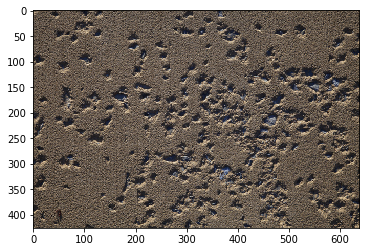

In [10]:
# Test: display a random background
_=backgrounds.get_random(display=True)

In [19]:
PATH = Path(r'instances.json')
CARDS = Path(r'data/alphas')
images, OGbbox  = get_annotations(PATH)

In [20]:
def get_random(card_num=None, display=False):
    if card_num is None:
        card_num= np.random.randint(len(images))
    card = cv2.imread(str(CARDS)+'/'+images[card_num], cv2.IMREAD_UNCHANGED)
    if display:
        bb = []
        for i in range(len(OGbbox[card_num][1])):
            y1,x1,y2,x2 = OGbbox[card_num][0][i]
            bb.append(np.array([[x1,y1],[x1,y2],[x2,y2],[x2,y1]]))
        
        display_img(card,bb,"bgr")
    else:
        return card

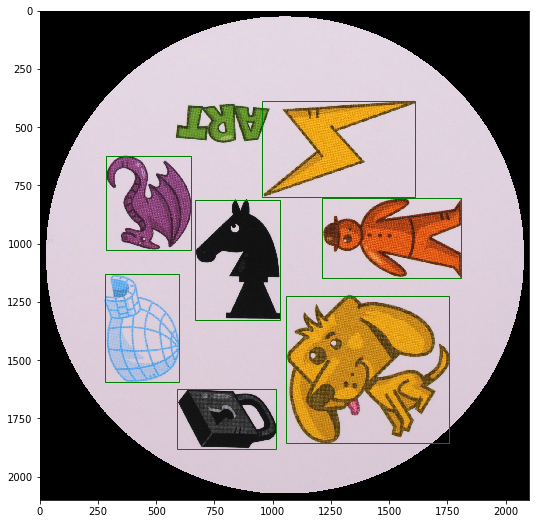

In [21]:
# Test: display a random card
get_random(display=True)
# Display a random Ace of spades
#_=cards.get_random("As",display=True)

### To save bounding boxes annotations in Pascal VOC format 
http://host.robots.ox.ac.uk/pascal/VOC/voc2008/htmldoc/

In [14]:
xml_body_1="""<annotation>
        <folder>FOLDER</folder>
        <filename>{FILENAME}</filename>
        <path>{PATH}</path>
        <source>
                <database>Unknown</database>
        </source>
        <size>
                <width>{WIDTH}</width>
                <height>{HEIGHT}</height>
                <depth>3</depth>
        </size>
"""
xml_object=""" <object>
                <name>{CLASS}</name>
                <pose>Unspecified</pose>
                <truncated>0</truncated>
                <difficult>0</difficult>
                <bndbox>
                        <xmin>{XMIN}</xmin>
                        <ymin>{YMIN}</ymin>
                        <xmax>{XMAX}</xmax>
                        <ymax>{YMAX}</ymax>
                </bndbox>
        </object>
"""
xml_body_2="""</annotation>        
"""

def create_voc_xml(xml_file, img_file,listbba,display=False):
    with open(xml_file,"w") as f:
        f.write(xml_body_1.format(**{'FILENAME':os.path.basename(img_file), 'PATH':img_file,'WIDTH':imgW,'HEIGHT':imgH}))
        for bba in listbba:            
            f.write(xml_object.format(**{'CLASS':bba.classname,'XMIN':bba.x1,'YMIN':bba.y1,'XMAX':bba.x2,'YMAX':bba.y2}))
        f.write(xml_body_2)
        if display: print("New xml",xml_file)
        


In [23]:
class BBA:  # Bounding box + annotations
    def __init__(self,bb,classname):      
        self.x1=int(round(bb[0]))
        self.y1=int(round(bb[1]))
        self.x2=int(round(bb[2]))
        self.y2=int(round(bb[3]))
        self.classname=classname
        
        
class Scene:
    def __init__(self,bg,imgs):
        rands = [0]*10
        decals = []
        if len(imgs) == 1:
            rands = np.random.randint(-imgW/8,imgW/8,2)
            size = int(imgW * 3/4)
            decals.append(int((imgW-size)/2 + rands[0]))
            decals.append(int((imgH-size)/2 + rands[1]))
        elif len(imgs) == 2:
            rands[0], rands[2] = np.random.randint(-imgW/16,imgW/16,2)
            rands[1], rands[3] = np.random.randint(-imgW/5,imgW/5,2)
            size = int(imgW * 3/8)
            decals.append(int((imgW-2*size)/3 + rands[0]))
            decals.append(int((imgH-size)/2 + rands[1]))
            decals.append(int((imgW-2*size)*2/3 + size + rands[2]))
            decals.append(int((imgH-size)/2 + rands[3]))
        elif len(imgs) == 3:
            rands[0], rands[2], rands[4] = np.random.randint(-imgW/64,imgW/64,3)
            rands[1], rands[3], rands[5] = np.random.randint(-imgW/5,imgW/5,3)
            size = int(imgW * 5/16)
            decals.append(int((imgW/32 + rands[0])))
            decals.append(int((imgW-size)/2 + rands[1]))
            decals.append(int((imgW-size)/2 + rands[2]))
            decals.append(int((imgW-size)/2 + rands[3]))
            decals.append(int((31*imgW/32 - size + rands[4])))
            decals.append(int((imgW-size)/2 + rands[5]))
        elif len(imgs) == 4:
            rands = np.random.randint(-imgW/64,imgW/64,8)
            size = int(imgW * 5/16)
            decals.append(int((imgW-size)/2 + rands[0]*16))
            decals.append(int((imgW/32 + rands[1])))
            decals.append(int((imgW-size)/2 + rands[2]))
            decals.append(int((imgW-size)/2 + imgW/16 + rands[3]))
            decals.append(int(imgW/32 + rands[4]))
            decals.append(int(31*imgW/32 - size + rands[5]))
            decals.append(int(31*imgW/32 - size + rands[6]))
            decals.append(int(31*imgW/32 - size + rands[7]))
            
        elif len(imgs) == 5:
            rands = np.random.randint(-imgW/16,imgW/16,10)
            size = int(imgW * 5/16)
            decals.append(int(imgW/16 + rands[0]))
            decals.append(int(imgW/16 + rands[1]))
            decals.append(int(15*imgW/16 - size + rands[2]))
            decals.append(int((imgW/16 + rands[3])))
            decals.append(int((imgW-size)/2 + rands[4]))
            decals.append(int((imgW-size)/2 + rands[5]))
            decals.append(int(imgW/16 + rands[6]))
            decals.append(int(15*imgW/16 - size + rands[7]))
            decals.append(int(15*imgW/16 - size + rands[8]))
            decals.append(int(15*imgW/16 - size + rands[9]))
        
        cards = []
        self.imgs = []
        self.listbba=[]
        self.bg = cv2.resize(bg, (imgW,imgH), interpolation=cv2.INTER_AREA)
        masks = []
        
        for i in range(len(imgs)):
            cards.append(cv2.imread(str(CARDS)+'/'+images[imgs[i]], cv2.IMREAD_UNCHANGED))
            cards[i] = cv2.resize(cards[i], (size, size), interpolation=cv2.INTER_LINEAR)
            cards[i] = cv2.cvtColor(cards[i], cv2.COLOR_BGRA2RGBA)
            self.imgs.append(np.zeros((imgH,imgW,4),dtype=np.uint8))
            self.imgs[i][decals[i*2+1]:decals[i*2+1]+size,decals[i*2]:decals[i*2]+size,:]=cards[i]
            self.listbba.append(BBA([decals[i*2],decals[i*2+1],decals[i*2]+size,decals[i*2+1]+size],"Card"))
            
        masks.append(self.imgs[0][:,:,3])
        masks[0] = np.stack([masks[0]]*3,-1)
        self.final = np.where(masks[0], self.imgs[0][:,:,0:3], self.bg) 
        for i in range(1,len(imgs)):
            masks.append(self.imgs[i][:,:,3])
            masks[i] = np.stack([masks[i]]*3,-1)
            self.final = np.where(masks[i], self.imgs[i][:,:,0:3], self.final)    


    def display(self):
        fig,ax=plt.subplots(1,figsize=(8,8))
        ax.imshow(self.final)
        for bb in self.listbba:
            rect=patches.Rectangle((bb.x1,bb.y1),bb.x2-bb.x1,bb.y2-bb.y1,linewidth=1,edgecolor='b',facecolor='none')
            ax.add_patch(rect)
    def res(self):
        return self.final
    def write_files(self,save_dir,display=False):
        jpg_fn, xml_fn=give_me_filename(save_dir, ["jpg","xml"])
        plt.imsave(jpg_fn,self.final)
        if display: print("New image saved in",jpg_fn)
        create_voc_xml(xml_fn,jpg_fn, self.listbba,display=display)

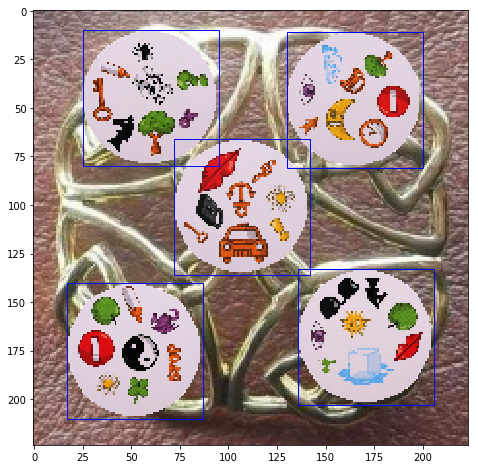

In [24]:
# Test generation of a scene with 5 cards
bg = backgrounds.get_random()
imgs = np.random.randint(len(images),size=5)

newimg = Scene(bg, imgs)
newimg.display()

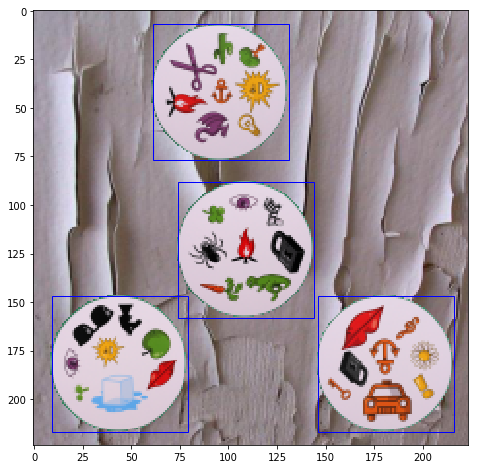

In [174]:
# Test generation of a scene with 4 cards
bg = backgrounds.get_random()
imgs = np.random.randint(len(images),size=4)

newimg = Scene(bg, imgs)
newimg.display()

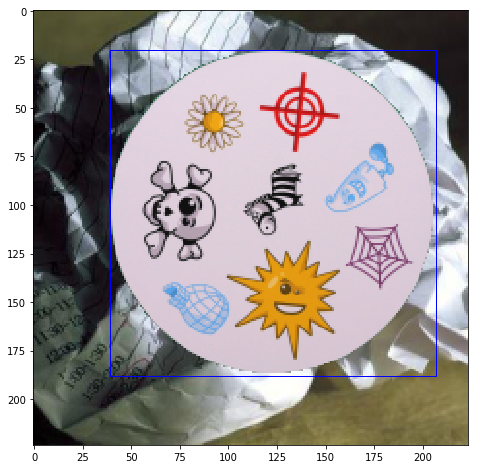

In [180]:
# Test generation of a scene with 1 card
bg = backgrounds.get_random()
imgs = np.random.randint(len(images), size = 1)

newimg = Scene(bg, imgs)
newimg.display()

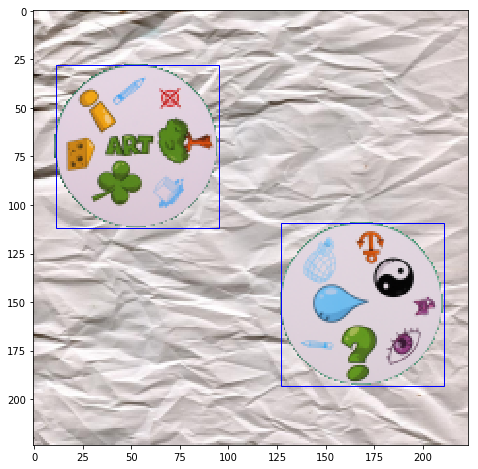

In [179]:
# Test generation of a scene with 2 cards
bg = backgrounds.get_random()
imgs = np.random.randint(len(images),size=2)

newimg = Scene(bg, imgs)
newimg.display()

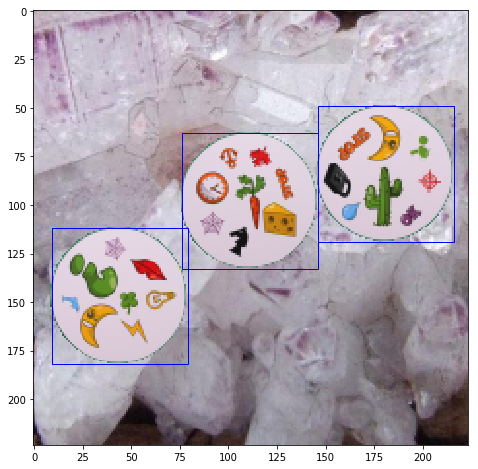

In [178]:
# Test generation of a scene with 3 cards
bg = backgrounds.get_random()
imgs = np.random.randint(len(images), size = 3)

newimg = Scene(bg, imgs)
newimg.display()

## Generate the datasets
Typically, you want to generate a training dataset and a validation dataset of different size and different destination directory.
Modify the variable 'nb_cards_to_generate' and 'save_dir' accordingly


### Generation of the 1 card scenes

In [25]:
nb_cards_to_generate=600
save_dir="data/cardBB"

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

for i in tqdm(range(nb_cards_to_generate)):
    bg = backgrounds.get_random()
    imgs = np.random.randint(len(images), size = 1)
    newimg = Scene(bg, imgs)
    newimg.write_files(save_dir)
    
    bg = backgrounds.get_random()
    imgs = np.random.randint(len(images), size = 2)
    newimg = Scene(bg, imgs)
    newimg.write_files(save_dir)
    
    bg = backgrounds.get_random()
    imgs = np.random.randint(len(images), size = 3)
    newimg = Scene(bg, imgs)
    newimg.write_files(save_dir)
    
    bg = backgrounds.get_random()
    imgs = np.random.randint(len(images), size = 4)
    newimg = Scene(bg, imgs)
    newimg.write_files(save_dir)
    
    bg = backgrounds.get_random()
    imgs = np.random.randint(len(images), size = 5)
    newimg = Scene(bg, imgs)
    newimg.write_files(save_dir)

100%|██████████| 600/600 [14:29<00:00,  1.56s/it]


### Generation of the 2 cards scenes

In [32]:
nb_cards_to_generate=400
save_dir="data/scenes/val"

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

for i in tqdm(range(nb_cards_to_generate)):
    bg = backgrounds.get_random()
    img1 = np.random.randint(len(images))
    img2 = np.random.randint(len(images))
    
    newimg = Scene(bg, img1, img2)
    newimg.write_files(save_dir)


100%|██████████| 100/100 [00:35<00:00,  2.88it/s]


### Generation of the 3 cards scenes

In [33]:
nb_cards_to_generate=400
save_dir="data/scenes/val"

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

for i in tqdm(range(nb_cards_to_generate)):
    bg = backgrounds.get_random()
    img1 = np.random.randint(len(images))
    img2 = np.random.randint(len(images))
    img3 = np.random.randint(len(images))
    
    newimg = Scene(bg, img1, img2, img3)
    newimg.write_files(save_dir)

100%|██████████| 100/100 [00:47<00:00,  2.12it/s]
